In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from PIL import Image

import os
from pathlib import Path
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

class KeypointDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, max_images=None):
        """
        Args:
            images_dir (str or Path): Directory containing image files.
            labels_dir (str or Path): Directory containing label files.
            transform (callable, optional): A torchvision.transforms transformation to apply.
            max_images (int, optional): If set, cap the dataset to at most max_images images.
        """
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        # Only include images that have a matching label file.
        self.image_paths = [p for p in self.images_dir.glob("*.jpg")
                            if (self.labels_dir / f"{p.stem}.txt").exists()]
        if max_images is not None:
            self.image_paths = self.image_paths[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image.
        image_path = self.image_paths[idx]
        img = cv2.imread(str(image_path))
        if img is None:
            raise RuntimeError(f"Failed to load image: {image_path}")
        # Convert from BGR to RGB.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply transformations if provided (expects a PIL Image).
        if self.transform:
            img = Image.fromarray(img)
            image_tensor = self.transform(img)
        else:
            image_tensor = torch.tensor(img).permute(2, 0, 1).float() / 255.0

        # Load keypoint labels.
        label_path = self.labels_dir / (image_path.stem + ".txt")
        with open(label_path, 'r') as f:
            line = f.readline().strip()
        parts = line.split()
        # Skip the first token (dummy class id).
        kp_values = parts[1:]
        # Convert to numpy array and reshape to (num_keypoints, 3)
        kp_array = np.array(kp_values, dtype=float).reshape(-1, 3)
        # Remove first entry of each keypoint (the class id)
        kp_array = kp_array[:, 0:2]
        # Convert to tensor.
        label_tensor = torch.tensor(kp_array, dtype=torch.float32)
        # Flatten the label tensor to match the network's output (batch x 26)
        label_tensor = label_tensor.view(-1)
        
        return image_tensor, label_tensor


transform = transforms.Compose([
transforms.Resize((220, 220)),
transforms.ToTensor()
])

dataset = KeypointDataset('../datasets/train_subset_single/standardized_images',
                    '../datasets/train_subset_single/labels',
                    transform=transform,
                    max_images=5000)

# Split dataset: 80% training, 20% validation.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)



tensor([0.4109, 0.4988, 0.6562, 0.4895, 0.4359, 0.9204, 0.8266, 0.5105, 0.0000,
        0.0000, 0.7297, 0.2881, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


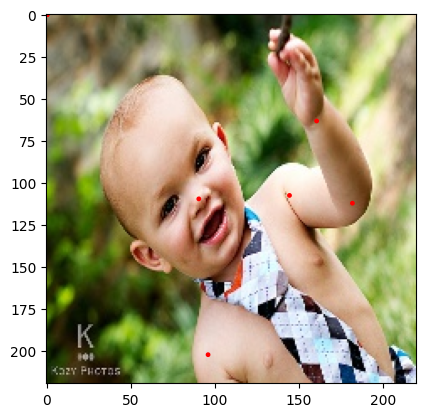

In [6]:
#vizualize labels on elements of the dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_keypoints(image, keypoints):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for i in range(0, len(keypoints), 2):
        x, y = keypoints[i]*220, keypoints[i+1]*220
        ax.add_patch(patches.Circle((x, y), radius=1, color='r'))
    plt.show()

image, keypoints = dataset[0]
print(keypoints)
image = image.permute(1, 2, 0).numpy()
keypoints = keypoints.numpy()
plot_keypoints(image, keypoints)

